In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
from collections import defaultdict
import pathlib
import tifffile
from sklearn.metrics import jaccard_score
from tqdm import tqdm

def find_contrasting_cases(df):
    """Find cases with contrasting performance, ignoring zero values."""
    # Group data by image
    image_data = defaultdict(lambda: defaultdict(dict))
    
    # Filter out zero values
    df_filtered = df[df['J_value'] > 0.001]
    
    # First, organize data by image -> label -> competitor -> score
    for _, row in df_filtered.iterrows():
        image = row['Gt_source_file']
        label = row['Label']
        competitor = row['competitor_name']
        score = row['J_value']
        image_data[image][label][competitor] = score
    
    interesting_cases = []
    
    # Analyze each image
    for image, label_data in image_data.items():
        # Only consider images with multiple labels
        if len(label_data) < 2:
            continue
            
        # Calculate mean score per competitor per label
        competitor_label_scores = defaultdict(dict)
        for label, comp_scores in label_data.items():
            for competitor, score in comp_scores.items():
                competitor_label_scores[competitor][label] = score
        
        # Look for contrasting performance
        for comp1 in competitor_label_scores:
            for comp2 in competitor_label_scores:
                if comp1 >= comp2:
                    continue
                    
                performance_diff = []
                for label in label_data:
                    # Only consider labels where both competitors have scores
                    if label in competitor_label_scores[comp1] and label in competitor_label_scores[comp2]:
                        diff = competitor_label_scores[comp1][label] - competitor_label_scores[comp2][label]
                        performance_diff.append((label, diff))
                
                # Check if there are contrasting performances (positive and negative differences)
                pos_diffs = [d for _, d in performance_diff if d > 0]
                neg_diffs = [d for _, d in performance_diff if d < 0]
                
                if pos_diffs and neg_diffs:  # If we have both positive and negative differences
                    max_contrast = max(pos_diffs) + abs(min(neg_diffs))  # Total contrast magnitude
                    
                    interesting_cases.append({
                        'image': image,
                        'competitor1': comp1,
                        'competitor2': comp2,
                        'contrast_magnitude': max_contrast,
                        'label_differences': performance_diff,
                        'scores': {
                            comp1: competitor_label_scores[comp1],
                            comp2: competitor_label_scores[comp2]
                        }
                    })
    
    # Sort cases by contrast magnitude
    interesting_cases.sort(key=lambda x: x['contrast_magnitude'], reverse=True)
    return interesting_cases


def create_silver_truth_df(overall_scores, df):
    """Convert silver truth dict to DataFrame matching the structure of the main df"""
    st_rows = []
    
    for st_image_path, scores in overall_scores.items():
        # Extract corresponding GT source file
        # gt_source_file = str(pathlib.Path(*st_image_path.split('_ST_sync')[0].split('/')[:-1], 
        #                                 st_image_path.split('/')[-1]))
        input_folder, dataset, inner_split, seg, filename = st_image_path.split('/')
        split_number = inner_split.split('_')[0]
        filename = filename.replace('man_seg', 't')
        gt_source_file = str(pathlib.Path(input_folder, dataset, split_number,filename))
        # Extract corresponding GT mask file
        input_folder, dataset, inner_split, seg, filename = st_image_path.split('/')
        split_number = inner_split.split('_')[0]
        gt_mask_file = str(pathlib.Path(input_folder, dataset, f"{split_number}_GT", seg, filename))
        for label, j_value in scores.items():
            st_rows.append({
                'Mask_file': st_image_path,
                'Gt_source_file': gt_source_file,
                'Gt_mask_file': gt_mask_file,
                'Label': label,
                'J_value': j_value,
                'competitor_name': 'Silver Truth'  # Special competitor name for silver truth
            })
    
    st_df = pd.DataFrame(st_rows)
    return pd.concat([df, st_df], ignore_index=True)

def visualize_contrasting_case(case, df, max_labels=10, show_all=False):
    """
    Visualize performance case with silver truth highlighted.
    """
    comp1 = case['competitor1']
    comp2 = case['competitor2']
    
    # Get all labels and scores for this image
    image = case['image']
    image_data = df[df['Gt_source_file'] == image]
    
    # Filter out zero values
    image_data = image_data[image_data['J_value'] > 0.001]
    
    # Get all unique competitors for this image
    all_competitors = sorted(comp for comp in image_data['competitor_name'].unique() 
                           if comp != 'Silver Truth')
    
    # Get all labels that have non-zero values for at least one of our main competitors
    main_comp_data = image_data[image_data['competitor_name'].isin([comp1, comp2])]
    all_labels = sorted(main_comp_data['Label'].unique())
    
    # Select most interesting labels if we have more than max_labels
    if len(all_labels) > max_labels:
        label_interests = []
        for label in all_labels:
            label_data = image_data[image_data['Label'] == label]
            scores_dict = {row['competitor_name']: row['J_value'] 
                          for _, row in label_data.iterrows()}
            
            # Calculate variance of scores for this label (excluding silver truth)
            scores = [v for k, v in scores_dict.items() if k != 'Silver Truth']
            variance = np.var(scores) if scores else 0
            
            # Calculate difference between main competitors if both present
            main_diff = 0
            if comp1 in scores_dict and comp2 in scores_dict:
                main_diff = abs(scores_dict[comp1] - scores_dict[comp2])
            
            interestingness = variance + main_diff
            label_interests.append((label, interestingness))
        
        label_interests.sort(key=lambda x: x[1], reverse=True)
        selected_labels = sorted([label for label, _ in label_interests[:max_labels]])
    else:
        selected_labels = all_labels
    
    # Create mapping from original labels to sequential numbers
    label_to_seq = {label: idx + 1 for idx, label in enumerate(selected_labels)}
    seq_to_label = {idx + 1: label for idx, label in enumerate(selected_labels)}
    
    plt.figure(figsize=(12, 7))
    
    if show_all:
        # Use a color palette for all competitors
        colors = plt.cm.tab20(np.linspace(0, 1, len(all_competitors)))
        
        # Plot all competitors
        for idx, competitor in enumerate(all_competitors):
            comp_data = image_data[image_data['competitor_name'] == competitor]
            scores = []
            x_values = []
            
            for label in selected_labels:
                label_score = comp_data[comp_data['Label'] == label]['J_value']
                if not label_score.empty and label_score.iloc[0] > 0.001:
                    scores.append(label_score.iloc[0])
                    x_values.append(label_to_seq[label])
            
            if scores:
                plt.plot(x_values, scores, '-o', color=colors[idx], 
                        label=competitor, linewidth=2, markersize=6)
    else:
        # First plot other competitors in muted colors
        for competitor in all_competitors:
            if competitor not in [comp1, comp2]:
                comp_data = image_data[image_data['competitor_name'] == competitor]
                scores = []
                x_values = []
                
                for label in selected_labels:
                    label_score = comp_data[comp_data['Label'] == label]['J_value']
                    if not label_score.empty and label_score.iloc[0] > 0.001:
                        scores.append(label_score.iloc[0])
                        x_values.append(label_to_seq[label])
                
                if scores:
                    plt.plot(x_values, scores, '-o', color='gray', alpha=0.2, 
                            linewidth=1, markersize=4)

        # Plot the two main competitors
        for competitor, color in [(comp1, '#FF6B6B'), (comp2, '#4ECDC4')]:
            comp_data = image_data[image_data['competitor_name'] == competitor]
            scores = []
            x_values = []
            
            for label in selected_labels:
                label_score = comp_data[comp_data['Label'] == label]['J_value']
                if not label_score.empty and label_score.iloc[0] > 0.001:
                    scores.append(label_score.iloc[0])
                    x_values.append(label_to_seq[label])
            
            if scores:
                plt.plot(x_values, scores, '-o', color=color, alpha=1, 
                        label=competitor, linewidth=2.5, markersize=8)
    
    # Always plot silver truth last and with special styling
    st_data = image_data[image_data['competitor_name'] == 'Silver Truth']
    st_scores = []
    st_x_values = []
    
    for label in selected_labels:
        st_score = st_data[st_data['Label'] == label]['J_value']
        if not st_score.empty and st_score.iloc[0] > 0.001:
            st_scores.append(st_score.iloc[0])
            st_x_values.append(label_to_seq[label])
    
    if st_scores:
        plt.plot(st_x_values, st_scores, '-*', color='gold', 
                label='Silver Truth', linewidth=2.5, markersize=12,
                #path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='black')]
                )

    plt.xlabel('Sequential Label Number (Original Label)')
    plt.ylabel('Jaccard Score')
    
    if show_all:
        plt.title(f'All Competitors Performance in Image:\n{image.split("/")[-1]}')
    else:
        plt.title(f'Contrasting Performance in Image:\n{image.split("/")[-1]}')
    
    plt.grid(True, alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    valid_scores = image_data['J_value'][image_data['J_value'] > 0.001]
    if not valid_scores.empty:
        plt.ylim(max(0, valid_scores.min() - 0.1), 
                 min(1, valid_scores.max() + 0.1))
    
    x_ticks = list(label_to_seq.values())
    plt.xticks(x_ticks, [f'{seq} ({seq_to_label[seq]})' for seq in x_ticks], rotation=45)
    plt.xlim(min(x_ticks) - 0.5, max(x_ticks) + 0.5)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

def analyze_contrasting_performance(df, overall_scores):
    # First, incorporate silver truth into the DataFrame
    enhanced_df = create_silver_truth_df(overall_scores, df)
    
    # Then proceed with the analysis
    cases = find_contrasting_cases(enhanced_df)
    
    if not cases:
        print("No contrasting cases found!")
        return
    
    print("\nTop Contrasting Performance Cases:")
    print("-" * 80)
    
    for i, case in enumerate(cases[:3], 1):
        print(f"\nCase {i}:")
        print(f"Image: {case['image'].split('/')[-1]}")
        print(f"Competitors: {case['competitor1']} vs {case['competitor2']}")
        print(f"Contrast Magnitude: {case['contrast_magnitude']:.3f}")
        
        # Add silver truth comparison
        st_data = enhanced_df[
            (enhanced_df['Gt_source_file'] == case['image']) & 
            (enhanced_df['competitor_name'] == 'Silver Truth')
        ]
        
        print("\nLabel-wise comparison (including Silver Truth):")
        for label, diff in case['label_differences']:
            print(f"\nLabel {label}:")
            print(f"  {case['competitor1']}: {case['scores'][case['competitor1']][label]:.3f}")
            print(f"  {case['competitor2']}: {case['scores'][case['competitor2']][label]:.3f}")
            
            st_score = st_data[st_data['Label'] == label]['J_value'].iloc[0] \
                if not st_data[st_data['Label'] == label].empty else None
            if st_score is not None:
                print(f"  Silver Truth: {st_score:.3f}")
        
        # Visualize with contrasting competitors highlighted
        fig1 = visualize_contrasting_case(case, enhanced_df, show_all=False)
        plt.show()
        
        # Visualize with all competitors equally
        fig2 = visualize_contrasting_case(case, enhanced_df, show_all=True)
        plt.show()
            
    return cases, enhanced_df

# Usage:
# cases, enhanced_df = analyze_contrasting_performance(df, overall_scores)


In [9]:
def calculate_jaccard_scores(gt_image, mask_image):
    labels = np.unique(gt_image)[1:]
    scores = {}
    for label in labels:
        label_layer = np.zeros_like(gt_image)
        label_layer[gt_image == label] = 1
        mask_layer = np.zeros_like(mask_image) 
        mask_layer[mask_image == label] = 1
        j = jaccard_score(label_layer, mask_layer, average='micro')
        scores[label] = j
    return scores
def get_competitor_name(file_path: str):
    """returns the competitor folder name given a path to a file."""
    return file_path.split('/')[2]

# open corresponding silvertruth:
def find_silvertruth_image(gt_image_path: str) -> str:
    input_folder, dataset, inner_split, seg, filename = gt_image_path.split('/')
    silvertruth_image_path = pathlib.Path(input_folder, dataset, f"{inner_split.replace('G', 'S')}_sync", seg, filename)
    return str(silvertruth_image_path)

def find_gt_image(gt_image_path: str) -> str:
    input_folder, dataset, inner_split, seg, filename = gt_image_path.split('/')
    synced_gt_image_path = pathlib.Path(input_folder, dataset, f"{inner_split}_sync", filename)
    return str(synced_gt_image_path)

df = pd.read_csv('preprocessed_dataset.csv')
df['competitor_name'] = df['Mask_file'].apply(get_competitor_name)


gt_source_files = list(df.drop_duplicates(subset=['Gt_mask_file'])['Gt_mask_file'])


In [10]:
overall_scores = {}
for gt_image_path in tqdm(gt_source_files):
    synced_gt_image_path = find_gt_image(gt_image_path)
    gt_image = tifffile.imread(synced_gt_image_path)
    st_image_path = find_silvertruth_image(gt_image_path)
    st_image = tifffile.imread(st_image_path)
    #print(gt_image_path)
    labels = np.unique(gt_image)[1:]
    scores = {}
    # This is most likely wrong, but let's just have those values shrank to values from 1 to x
    for order, label in enumerate(labels):
        label_layer = np.zeros_like(gt_image)
        label_layer[gt_image == label] = 1
        mask_layer = np.zeros_like(st_image) 
        mask_layer[st_image == label] = 1
        j = np.round(jaccard_score(label_layer, mask_layer, average='micro'),6)
        scores[order+1] = j
    overall_scores[st_image_path] = scores
    

100%|███████████████████████████████████████████| 57/57 [00:18<00:00,  3.10it/s]



Top Contrasting Performance Cases:
--------------------------------------------------------------------------------

Case 1:
Image: t1748.tif
Competitors: CALT-US vs KIT-Sch-GE
Contrast Magnitude: 0.921

Label-wise comparison (including Silver Truth):

Label 1:
  CALT-US: 0.753
  KIT-Sch-GE: 0.302
  Silver Truth: 0.732

Label 2:
  CALT-US: 0.867
  KIT-Sch-GE: 0.869
  Silver Truth: 0.872

Label 3:
  CALT-US: 0.916
  KIT-Sch-GE: 0.881
  Silver Truth: 0.931

Label 4:
  CALT-US: 0.860
  KIT-Sch-GE: 0.773
  Silver Truth: 0.857

Label 5:
  CALT-US: 0.440
  KIT-Sch-GE: 0.910
  Silver Truth: 0.870

Label 6:
  CALT-US: 0.916
  KIT-Sch-GE: 0.868
  Silver Truth: 0.869

Label 7:
  CALT-US: 0.884
  KIT-Sch-GE: 0.825
  Silver Truth: 0.870

Label 8:
  CALT-US: 0.823
  KIT-Sch-GE: 0.833
  Silver Truth: 0.855

Label 9:
  CALT-US: 0.887
  KIT-Sch-GE: 0.887
  Silver Truth: 0.914

Label 10:
  CALT-US: 0.892
  KIT-Sch-GE: 0.843
  Silver Truth: 0.846

Label 11:
  CALT-US: 0.460
  KIT-Sch-GE: 0.869
  Silver

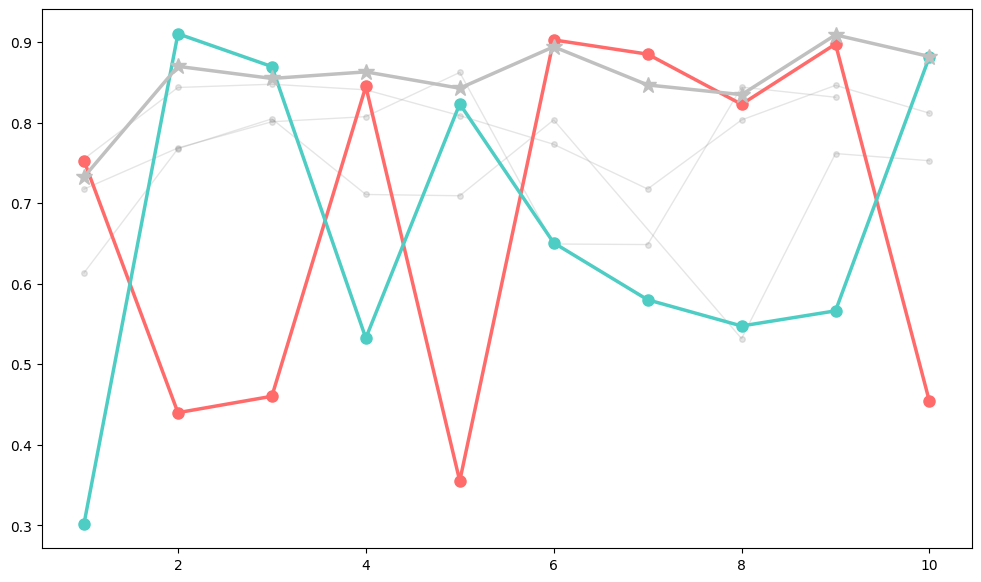

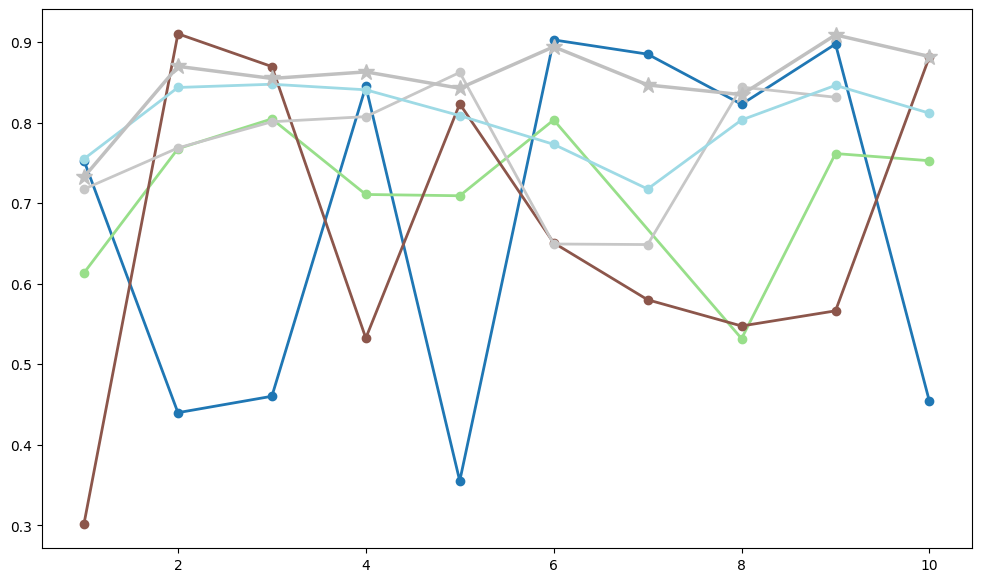


Case 2:
Image: t1585.tif
Competitors: KIT-Sch-GE vs MU-Lux-CZ
Contrast Magnitude: 0.856

Label-wise comparison (including Silver Truth):

Label 1:
  KIT-Sch-GE: 0.268
  MU-Lux-CZ: 0.801
  Silver Truth: 0.686

Label 2:
  KIT-Sch-GE: 0.863
  MU-Lux-CZ: 0.833
  Silver Truth: 0.897

Label 3:
  KIT-Sch-GE: 0.775
  MU-Lux-CZ: 0.791
  Silver Truth: 0.816

Label 4:
  KIT-Sch-GE: 0.852
  MU-Lux-CZ: 0.812
  Silver Truth: 0.870

Label 5:
  KIT-Sch-GE: 0.867
  MU-Lux-CZ: 0.855
  Silver Truth: 0.898

Label 6:
  KIT-Sch-GE: 0.868
  MU-Lux-CZ: 0.854
  Silver Truth: 0.912

Label 7:
  KIT-Sch-GE: 0.898
  MU-Lux-CZ: 0.787
  Silver Truth: 0.889

Label 8:
  KIT-Sch-GE: 0.850
  MU-Lux-CZ: 0.716
  Silver Truth: 0.882

Label 9:
  KIT-Sch-GE: 0.590
  MU-Lux-CZ: 0.893
  Silver Truth: 0.864

Label 10:
  KIT-Sch-GE: 0.855
  MU-Lux-CZ: 0.871
  Silver Truth: 0.886

Label 11:
  KIT-Sch-GE: 0.823
  MU-Lux-CZ: 0.798
  Silver Truth: 0.923

Label 12:
  KIT-Sch-GE: 0.725
  MU-Lux-CZ: 0.859
  Silver Truth: 0.805

Label 

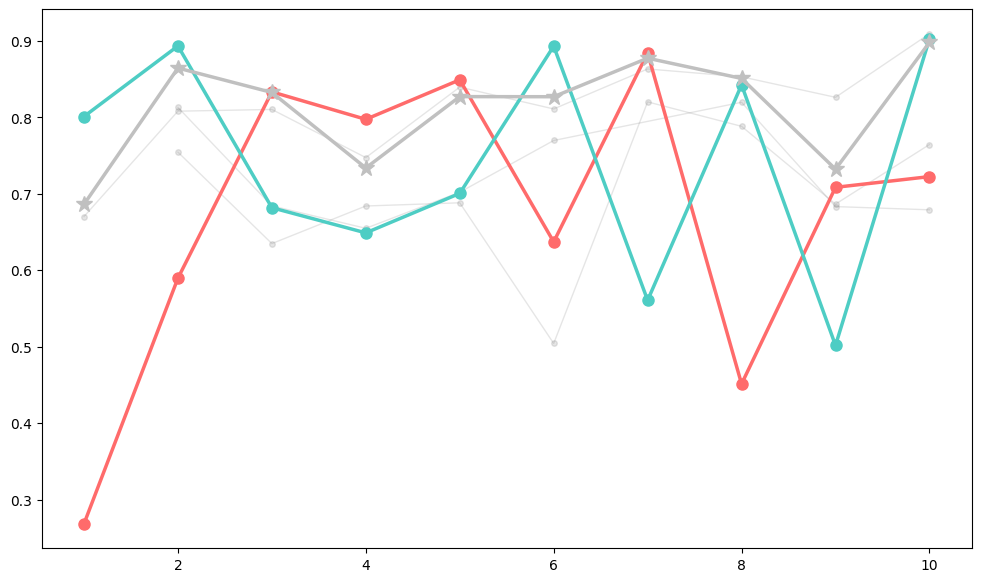

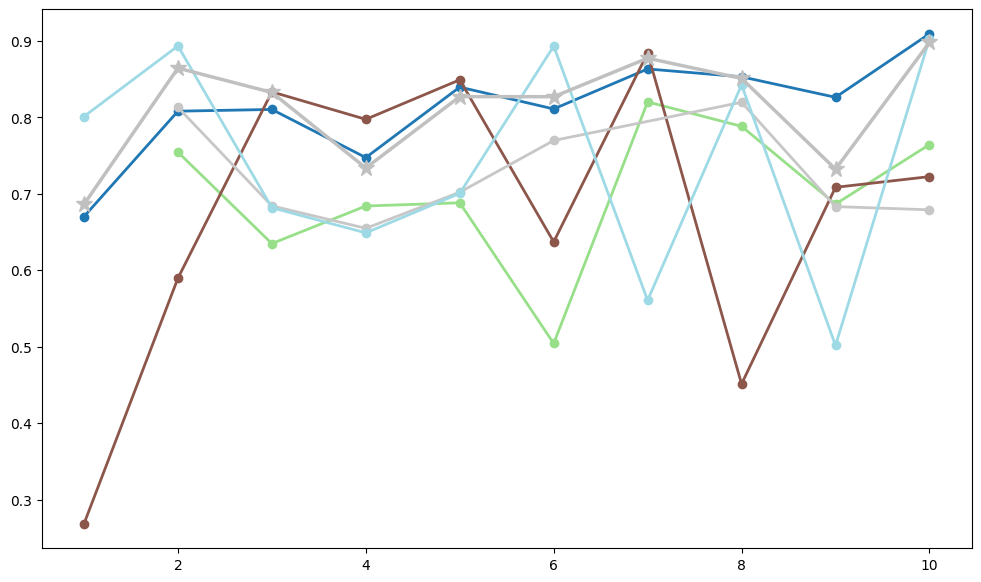


Case 3:
Image: t1585.tif
Competitors: DREX-US vs KIT-Sch-GE
Contrast Magnitude: 0.798

Label-wise comparison (including Silver Truth):

Label 2:
  DREX-US: 0.803
  KIT-Sch-GE: 0.863
  Silver Truth: 0.897

Label 3:
  DREX-US: 0.740
  KIT-Sch-GE: 0.775
  Silver Truth: 0.816

Label 4:
  DREX-US: 0.824
  KIT-Sch-GE: 0.852
  Silver Truth: 0.870

Label 5:
  DREX-US: 0.711
  KIT-Sch-GE: 0.867
  Silver Truth: 0.898

Label 6:
  DREX-US: 0.738
  KIT-Sch-GE: 0.868
  Silver Truth: 0.912

Label 7:
  DREX-US: 0.803
  KIT-Sch-GE: 0.898
  Silver Truth: 0.889

Label 8:
  DREX-US: 0.779
  KIT-Sch-GE: 0.850
  Silver Truth: 0.882

Label 9:
  DREX-US: 0.755
  KIT-Sch-GE: 0.590
  Silver Truth: 0.864

Label 10:
  DREX-US: 0.699
  KIT-Sch-GE: 0.855
  Silver Truth: 0.886

Label 11:
  DREX-US: 0.890
  KIT-Sch-GE: 0.823
  Silver Truth: 0.923

Label 12:
  DREX-US: 0.627
  KIT-Sch-GE: 0.725
  Silver Truth: 0.805

Label 13:
  DREX-US: 0.748
  KIT-Sch-GE: 0.853
  Silver Truth: 0.854

Label 14:
  DREX-US: 0.786
  KI

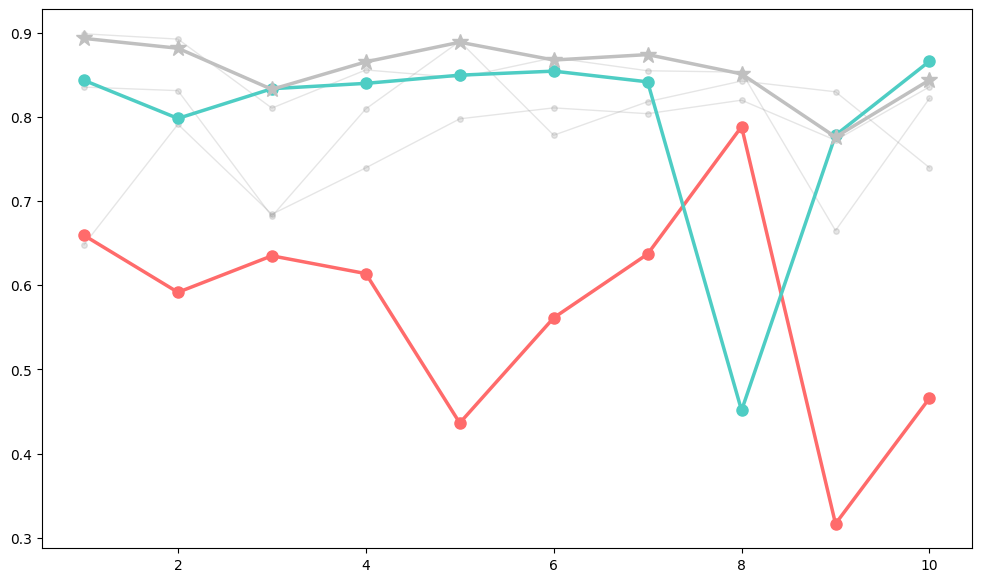

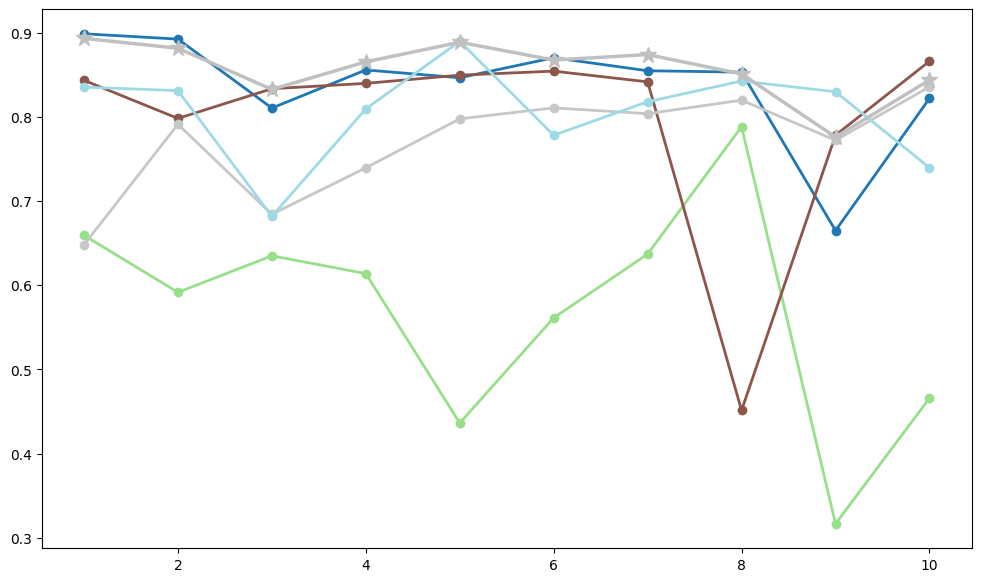

In [11]:
cases, enhanced_df = analyze_contrasting_performance(df, overall_scores)

In [40]:
enhanced_df

,Unnamed: 0,Mask_file,Gt_source_file,Gt_mask_file,Label,J_value,merged_image_path,competitor_name
0,0.0,inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...,inputs-2020-07/BF-C2DL-HSC/02/t0046.tif,inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...,1,0.861789,test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...,MU-Lux-CZ
1,1.0,inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...,inputs-2020-07/BF-C2DL-HSC/02/t0046.tif,inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...,2,0.830097,test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...,MU-Lux-CZ
2,2.0,inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...,inputs-2020-07/BF-C2DL-HSC/02/t0056.tif,inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...,1,0.780928,test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...,MU-Lux-CZ
3,3.0,inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...,inputs-2020-07/BF-C2DL-HSC/02/t0056.tif,inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...,2,0.720430,test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...,MU-Lux-CZ
4,4.0,inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...,inputs-2020-07/BF-C2DL-HSC/02/t0287.tif,inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg02...,1,0.863874,test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...,MU-Lux-CZ
...,...,...,...,...,...,...,...,...
3379,NaN,inputs-2020-07/BF-C2DL-HSC/01_ST_sync/SEG/man_...,inputs-2020-07/BF-C2DL-HSC/01/t1743.tif,inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...,8,0.880597,NaN,Silver Truth
3380,NaN,inputs-2020-07/BF-C2DL-HSC/01_ST_sync/SEG/man_...,inputs-2020-07/BF-C2DL-HSC/01/t1743.tif,inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...,9,0.917178,NaN,Silver Truth
3381,NaN,inputs-2020-07/BF-C2DL-HSC/01_ST_sync/SEG/man_...,inputs-2020-07/BF-C2DL-HSC/01/t1743.tif,inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...,10,0.910180,NaN,Silver Truth
3382,NaN,inputs-2020-07/BF-C2DL-HSC/01_ST_sync/SEG/man_...,inputs-2020-07/BF-C2DL-HSC/01/t1743.tif,inputs-2020-07/BF-C2DL-HSC/01_GT/SEG/man_seg17...,11,0.891473,NaN,Silver Truth


In [38]:
source_file_filtered = enhanced_df[enhanced_df['Gt_source_file'] == 'inputs-2020-07/BF-C2DL-HSC/02/t0046.tif']
label_filtered = source_file_filtered[source_file_filtered['Label'] == 1]
comp_results = {}
for row in label_filtered.iterrows():
    print(row)
    comp_results[row[1]['competitor_name']] = row[1]['J_value']
    comp_results[row[1].competitor_name] = row[1]['Label']
    

(0, Unnamed: 0                                                         0.0
Mask_file            inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/ma...
Gt_source_file                 inputs-2020-07/BF-C2DL-HSC/02/t0046.tif
Gt_mask_file         inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
Label                                                                1
J_value                                                       0.861789
merged_image_path    test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/...
competitor_name                                              MU-Lux-CZ
Name: 0, dtype: object)
(564, Unnamed: 0                                                         0.0
Mask_file            inputs-2020-07/BF-C2DL-HSC/CALT-US/02_RES/mask...
Gt_source_file                 inputs-2020-07/BF-C2DL-HSC/02/t0046.tif
Gt_mask_file         inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg00...
Label                                                                1
J_value                                    

In [41]:
source_file_filtered = enhanced_df[enhanced_df['Gt_source_file'] == 'inputs-2020-07/BF-C2DL-HSC/02/t0046.tif']


In [44]:
'inputs-2020-07/BF-C2DL-HSC/02/t0046.tif' == 'inputs-2020-07/BF-C2DL-HSC/02/t0046.tif'

True

In [53]:
for row in source_file_filtered[:2].itertuples():
    print(row)

Pandas(Index=0, _1=0.0, Mask_file='inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/mask0046.tif', Gt_source_file='inputs-2020-07/BF-C2DL-HSC/02/t0046.tif', Gt_mask_file='inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0046.tif', Label=1, J_value=0.861789, merged_image_path='test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/mask0046_1.tif', competitor_name='MU-Lux-CZ')
Pandas(Index=1, _1=1.0, Mask_file='inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/mask0046.tif', Gt_source_file='inputs-2020-07/BF-C2DL-HSC/02/t0046.tif', Gt_mask_file='inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0046.tif', Label=2, J_value=0.830097, merged_image_path='test_out/inputs-2020-07/BF-C2DL-HSC/MU-Lux-CZ/02_RES/mask0046_2.tif', competitor_name='MU-Lux-CZ')


In [46]:
st_only = enhanced_df[enhanced_df['competitor_name'] == 'Silver Truth']

In [49]:
st_source_file_filtered = st_only[st_only['Gt_source_file'] == 'inputs-2020-07/BF-C2DL-HSC/02/t0046.tif']


In [50]:
st_source_file_filtered

,Unnamed: 0,Mask_file,Gt_source_file,Gt_mask_file,Label,J_value,merged_image_path,competitor_name


In [54]:
for row in st_only[:2].itertuples():
    print(row)

Pandas(Index=2820, _1=nan, Mask_file='inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0046.tif', Gt_source_file=PosixPath('inputs-2020-07/BF-C2DL-HSC/02/t0046.tif'), Gt_mask_file=PosixPath('inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0046.tif'), Label=1, J_value=0.883978, merged_image_path=nan, competitor_name='Silver Truth')
Pandas(Index=2821, _1=nan, Mask_file='inputs-2020-07/BF-C2DL-HSC/02_ST_sync/SEG/man_seg0046.tif', Gt_source_file=PosixPath('inputs-2020-07/BF-C2DL-HSC/02/t0046.tif'), Gt_mask_file=PosixPath('inputs-2020-07/BF-C2DL-HSC/02_GT/SEG/man_seg0046.tif'), Label=2, J_value=0.927614, merged_image_path=nan, competitor_name='Silver Truth')
